# <h1><center>Quality-Diversity Tutorial</center></h1>

This notebook provides an introductory tutorial to Quality-Diversity algorithms. Specifically, we will apply the [Multi-dimensional Archive of Phenotypic Elites (MAP-Elites)](https://arxiv.org/abs/1504.04909) algorithm to acquire a diverse set of locomotion behaviours for a simplified brittle star robot. The [brittle star robot and its environment](https://github.com/Co-Evolve/brb/tree/new-framework/brb/brittle_star) is part of the [**the Bio-inspired Robotics Benchmark (BRB)**](https://github.com/Co-Evolve/brb). Instead of directly evolving joint-level actions, we will evolve modulation parameters for a Central Pattern Generator, that in turn outputs the joint-level actions. This will allow us to generate a diverse repertoire of motion primitives for our brittle star robot, which can in turn be used by another controller that selects the optimal motion primitive given some observations.

## Quality-Diversity algorithms

Quality Diversity (QD) algorithms represent a significant advancement in evolutionary computation, combining elements from evolutionary algorithms and [novelty search](https://pubmed.ncbi.nlm.nih.gov/20868264/) to optimize a population of solutions based not only on their performance (quality) but also on their behavioral diversity. This approach is particularly relevant in fields like robotics, where diverse solutions can be more adaptable and robust to varying environments or tasks.

The core idea behind QD algorithms is to maintain a diverse collection of high-performing solutions. This contrasts with traditional optimization methods that focus solely on finding a single, optimal solution. QD algorithms are characterized by two main components:

- **Quality Measure**: This is typically the objective function that evaluates how well a solution performs a given task. In the context of robotics, this might involve tasks like navigation, manipulation, or interaction, where performance can be quantitatively measured.
- **Diversity Measure**: This is often based on behavioral characteristics of the solutions. For instance, in robotic locomotion, diversity might be measured in terms of different gait patterns, speed, energy efficiency, or stability under various conditions.

One of the seminal works in this area is the [Novelty Search with Local Competition (NSLC)](https://dl.acm.org/doi/10.1145/2001576.2001606) algorithm, introduced by Lehman and Stanley (2011). NSLC maintains diversity by rewarding individuals (candidate solutions to the problem) that exhibit novel behaviors, while also fostering competition based on performance in local neighborhoods of the behavior space.

Another notable QD algorithm is MAP-Elites, developed by Mouret and Clune (2015). This algorithm discretizes the behavior space into a grid of 'cells', each representing a unique combination of behavioral characteristics. The algorithm then seeks to fill each cell with the highest quality individual that exhibits the corresponding behaviors.

QD algorithms are particularly effective in complex, multimodal landscapes where traditional optimization methods might get trapped in local optima. In robotics, they have been used to evolve diverse repertoires of behaviors that can be adapted to unforeseen situations, leading to more robust and versatile robots.

## MAP-Elites
### The key concepts
1. **Elitism in a Multi-dimensional Space**: Unlike traditional evolutionary algorithms that maintain a population of individuals primarily based on fitness, MAP-Elites creates and maintains a multi-dimensional grid or "map" of solutions. Each cell in this grid represents a unique combination of behavioral characteristics (also known as phenotypic traits).
2. **Behavioral Dimensions**: These are pre-defined characteristics that are used to categorize solutions. For example, in robotic locomotion, dimensions could include speed, stability, energy efficiency, or gait type. The choice of dimensions is crucial as it determines the diversity of solutions.
3. **Illuminating the Search Space**: MAP-Elites aims to "illuminate" this high-dimensional space by finding the best possible solution (elite) for each cell in the grid. This process leads to a comprehensive understanding of how different traits affect performance and reveals trade-offs and synergies between different objectives.

### How does it work
1. **Initialization**: The algorithm starts with a randomly generated population of individuals. Each individual is evaluated both for its performance (fitness) and its behavior (to determine which cell of the grid it belongs to).
2. **Iteration**: At each iteration, the algorithm selects individuals from the map, applies genetic operators (like mutation and crossover), and then evaluates these offspring.
3. **Placement in the Map**: If an offspring performs better than the current inhabitant of its corresponding cell (based on its behavioral characteristics), it replaces the incumbent elite. If the cell is empty, the offspring simply takes its place.
4. **Diversity through Niches**: This process naturally encourages diversity since each cell represents a different niche in the behavior space. Even individuals with lower overall fitness can be retained if they are the best in their particular niche.


TODO ADD IMAGE OF ALGORITHM

### Advantages
* **Robustness and Versatility**: In robotics, MAP-Elites can generate a wide array of behaviors, which can be beneficial for robots operating in dynamic or unpredictable environments. If one of the discovered controllers does not work in the given setting, we have a whole other set of options as a back-up!
* **Discovery of Novel Solutions**: Because we explicitly stimulate novelty, the algorithm often uncovers innovative strategies and solutions that might not be found through traditional optimization methods focused on a single objective.
* **Parallelizability**: The algorithm is highly parallelizable, as each cell in the map can be evaluated independently, making it efficient for large-scale computational tasks and perfect to use with JAX.

### Implementing MAP-Elites in JAX
The next cell implements a basic version of the MAP-Elites algorithm in JAX. We assume a direct encoding of candidate solutions, consisting solely out of continuous parameters. The variation operator is limited to mutations (in this case adding Gaussian noise to the continuous parameters), and does not provide cross-over.

The central data structure is the `MAPElitesState`, which contains multiple sub-archives that are indexed based on the behavioural descriptor:
* The `parameter_archive`: maps the discretized behavioural descriptor (i.e. the cell index) to the parameters of the candidate solution currently stored in that cell.
* The `fitness_archive`: maps the discretized behavioural descriptor (i.e. the cell index) to the fitness of the candidate solution currently stored in that cell.
* The `descriptor_archive`: maps the discretized behavioural descriptor (i.e. the cell index) to the continuous form of the behavioural descriptor of the candidate solution currently stored in that cell.
* The `filled_mask`: maps a discretized behavioural descriptor (i.e. cell index) to a boolean, indicating whether that cell is actually occupied or not.


The initial population of candidate solutions is generated upon the `reset` call and their parameters are temporarily stored in the `MAPElitesState.parameter_archive`. As we also maintain the `filled_mask`, we are always able to discern parameters from the initial (random) popuation, and parameters that were evolved.

In [1]:
from functools import partial
import chex
import tqdm
from flax import struct
import jax.numpy as jnp
import jax
from typing import Tuple, Type, Callable


@struct.dataclass
class MAPElitesState:
    parameter_archive: jnp.ndarray
    fitness_archive: jnp.ndarray
    descriptor_archive: jnp.ndarray
    filled_mask: jnp.ndarray


class MAPElites:
    def __init__(
            self,
            dimensions: Tuple[int, ...],
            num_parameters: int,
            noise_scale: float,
            descriptor_low: jnp.ndarray,
            descriptor_high: jnp.ndarray,
            parameters_low: jnp.ndarray,
            parameters_high: jnp.ndarray,
            evaluation_fn: Callable[[chex.PRNGKey, jnp.ndarray], jnp.ndarray]
            ) -> None:
        self._dimensions = dimensions
        self._num_parameters = num_parameters
        self._noise_scale = noise_scale
        self._descriptor_low = descriptor_low
        self._descriptor_high = descriptor_high
        self._parameters_low = parameters_low
        self._parameters_high = parameters_high
        self._evaluation_fn = evaluation_fn

    @partial(jax.jit, static_argnums=(0,))
    def _select_random_parameters(
            self,
            rng: chex.PRNGKey,
            state: MAPElitesState
            ) -> jnp.ndarray:
        """
        Returns a random cell's parameters
        """
        cell_index = jax.random.randint(
                key=rng,
                shape=(len(self._dimensions),),
                minval=jnp.zeros(len(self._dimensions)),
                maxval=jnp.array(self._dimensions)
                )
        parameters = state.parameter_archive[*cell_index]
        return parameters

    @partial(jax.jit, static_argnums=(0,))
    def _mutate_parameters(
            self,
            rng: chex.PRNGKey,
            parameters: jnp.ndarray
            ) -> jnp.ndarray:
        """
        Mutates a candidate solution's parameters by adding Gaussian noise.
        """
        noise = jax.random.normal(key=rng, shape=(len(parameters),)) * self._noise_scale
        parameters = parameters + noise
        parameters = jnp.clip(a=parameters, a_min=self._parameters_low, a_max=self._parameters_high)
        return parameters

    @partial(jax.jit, static_argnums=(0,))
    def _get_cell_index(
            self,
            descriptor: jnp.ndarray
            ) -> Tuple[int, ...]:
        """
        Transforms a continuous behavioural descriptor into a discrete cell index, to be used in the sub archives.
        """
        descriptor = jnp.clip(a=descriptor, a_min=self._descriptor_low, a_max=self._descriptor_high)

        # Renormalize descriptor to [0, 1] range
        descriptor = (descriptor - self._descriptor_low) / (self._descriptor_high - self._descriptor_low)
        cell_index = (descriptor * jnp.array(self._dimensions)).astype(jnp.int32)
        return cell_index

    @partial(jax.jit, static_argnums=(0,))
    def _add_to_archive(
            self,
            state: MAPElitesState,
            descriptor: jnp.ndarray,
            fitness: float,
            parameters: jnp.ndarray
            ) -> MAPElitesState:
        """
        Adds a new candidate solution to the archives if either (1) Its corresponding cell is still empty, or (2) It received a higher fitness than the current occupant of the cell.
        """
        cell_index = self._get_cell_index(descriptor=descriptor)

        # Replace if the cell is empty, if not, the fitness of the new solution must be higher than what the solution currently in the cell
        should_replace = ~state.filled_mask[*cell_index] | (fitness > state.fitness_archive[*cell_index])

        def _replace() -> MAPElitesState:
            # noinspection PyUnresolvedReferences
            return state.replace(
                    parameter_archive=state.parameter_archive.at[*cell_index].set(parameters),
                    fitness_archive=state.fitness_archive.at[*cell_index].set(fitness),
                    descriptor_archive=state.descriptor_archive.at[*cell_index].set(descriptor),
                    filled_mask=state.filled_mask.at[*cell_index].set(True)
                    )

        def _do_not_replace() -> MAPElitesState:
            return state

        return jax.lax.cond(
                should_replace, _replace, _do_not_replace
                )

    @partial(jax.jit, static_argnums=(0,))
    def step(
            self,
            state: MAPElitesState,
            rng: chex.PRNGKey
            ) -> MAPElitesState:
        """
        Performs one complete iteration of the MAP-Elites algorithm.
        """
        selection_rng, mutation_rng, evaluation_rng = jax.random.split(key=rng, num=3)

        parameters = self._select_random_parameters(rng=selection_rng, state=state)
        parameters = self._mutate_parameters(rng=mutation_rng, parameters=parameters)

        fitness, descriptor = self._evaluation_fn(evaluation_rng, parameters)

        state = self._add_to_archive(
                state=state, fitness=fitness, descriptor=descriptor, parameters=parameters
                )

        return state

    @partial(jax.jit, static_argnums=(0,))
    def reset(
            self,
            rng: chex.PRNGKey
            ) -> MAPElitesState:
        """
        Returns a novel MAPElitesState datastructure with a random set of parameters stored in the parameters_archive.
        """
        # noinspection PyArgumentList
        return MAPElitesState(
                parameter_archive=jax.random.uniform(
                        key=rng,
                        shape=self._dimensions + (len(self._parameters_low),),
                        dtype=jnp.float32,
                        minval=self._parameters_low,
                        maxval=self._parameters_high
                        ),
                fitness_archive=-jnp.inf * jnp.ones(self._dimensions),
                descriptor_archive=jnp.zeros(self._dimensions + (len(self._descriptor_low),)),
                filled_mask=jnp.zeros(self._dimensions).astype(bool)
                )

## Case study: Evolving a behavioural repertoire for brittle star locomotion

Now that we have implemented our MAP-Elites algorithm, we will apply it to generate a diverse behavioural reportoire for brittle star locomotion. Simply said, we will try to fill our grid with a diverse and qualitative set of locomotion gaits.

While many behavioural descriptors are possible, here we will keep things simple and just take the final position of the robot on the XY plane after some simulation time. Given some target location, this kind of archive would thus allow us to simply select the controller that steers the brittle star to the target's XY location. As a quality metric, we will use the distance travelled over energy usage (i.e. if two gaits result in the same end position, we'll give preferene to the one that has a better distance over energy tradeoff).

We will encode our gaits by using central pattern generators (CPGs). CPGs excel at producing coordinated rhytmic output without any rhytmic input, and are therefore a solid choice to encode gaits with. A candidate solution in our case will thus correspond to the modulation parameters of a CPG system.

Its important to note that we are evolving 'open-loop' controllers, i.e. non-adaptive controllers. These controllers do not incorporate feedback in order to modify their operation or output.

### Environment setup

First things first, let's set up our brittle star simulation environment. We will use the undirected locomotion variant. The following cell will first do some preliminary checks to make sure that the underlying physics engine (MuJoCo) is correctly loaded and to make sure that JAX can access the GPU.

In [2]:
import os
import subprocess
import logging

try:
    if subprocess.run('nvidia-smi').returncode:
        raise RuntimeError(
                'Cannot communicate with GPU. '
                'Make sure you are using a GPU Colab runtime. '
                'Go to the Runtime menu and select Choose runtime type.'
                )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
            f.write(
                    """{
                            "file_format_version" : "1.0.0",
                            "ICD" : {
                                "library_path" : "libEGL_nvidia.so.0"
                            }
                        }
                        """
                    )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print('Setting environment variable to use GPU rendering:')
    %env MUJOCO_GL=egl

    xla_flags = os.environ.get('XLA_FLAGS', '')
    xla_flags += ' --xla_gpu_triton_gemm_any=True'
    os.environ['XLA_FLAGS'] = xla_flags

    # Check if jax finds the GPU
    import jax

    print(jax.devices('gpu'))
except Exception:
    logging.warning("Failed to initialize GPU. Everything will run on the cpu.")

try:
    print('Checking that the mujoco installation succeeded:')
    import mujoco

    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
            'Something went wrong during installation. Check the shell output above '
            'for more information.\n'
            'If using a hosted Colab runtime, make sure you enable GPU acceleration '
            'by going to the Runtime menu and selecting "Choose runtime type".'
            )

print('MuJoCo installation successful.')

Thu Feb  8 14:54:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A2                      On  | 00000000:3B:00.0 Off |                    0 |
|  0%   48C    P8               8W /  60W |      0MiB / 15356MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

This next cell (similar to previous tutorials) defines the `morphology_specification` (i.e. the brittle star morphology), the `arena_configuration` (i.e. some settings w.r.t. the aquarium in which we place the brittle star) and the `environment_configuration` (which defines and configures the undirected locomotion task). The cell also implements some utility functions for visualization.

In [3]:
from brb.brittle_star.environment.undirected_locomotion.dual import BrittleStarUndirectedLocomotionEnvironment
from brb.brittle_star.environment.undirected_locomotion.shared import \
    BrittleStarUndirectedLocomotionEnvironmentConfiguration
import numpy as np
from mujoco_utils.environment.base import MuJoCoEnvironmentConfiguration
from typing import List
import mediapy as media
from brb.brittle_star.mjcf.morphology.morphology import MJCFBrittleStarMorphology
from brb.brittle_star.mjcf.morphology.specification.default import default_brittle_star_morphology_specification
from brb.brittle_star.mjcf.arena.aquarium import AquariumArenaConfiguration, MJCFAquariumArena

morphology_specification = default_brittle_star_morphology_specification(
        num_arms=5, num_segments_per_arm=3, use_p_control=True, use_torque_control=False
        )
arena_configuration = AquariumArenaConfiguration(
        size=(3, 3), sand_ground_color=False, attach_target=False, wall_height=1.5, wall_thickness=0.1
        )
environment_configuration = BrittleStarUndirectedLocomotionEnvironmentConfiguration(
        joint_randomization_noise_scale=0.0,
        render_mode="rgb_array",
        simulation_time=5,
        num_physics_steps_per_control_step=10,
        time_scale=2,
        camera_ids=[0, 1],
        render_size=(480, 640)
        )


def create_environment() -> BrittleStarUndirectedLocomotionEnvironment:
    morphology = MJCFBrittleStarMorphology(
            specification=morphology_specification
            )
    arena = MJCFAquariumArena(
            configuration=arena_configuration
            )
    env = BrittleStarUndirectedLocomotionEnvironment.from_morphology_and_arena(
            morphology=morphology, arena=arena, configuration=environment_configuration, backend="MJX"
            )
    return env


def post_render(
        render_output: List[np.ndarray],
        environment_configuration: MuJoCoEnvironmentConfiguration
        ) -> np.ndarray:
    if render_output is None:
        # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
        return None

    num_cameras = len(environment_configuration.camera_ids)
    num_envs = len(render_output) // num_cameras

    if num_cameras > 1:
        # Horizontally stack frames of the same environment
        frames_per_env = np.array_split(render_output, num_envs)
        render_output = [np.concatenate(env_frames, axis=1) for env_frames in frames_per_env]

    # Vertically stack frames of different environments
    render_output = np.concatenate(render_output, axis=0)

    return render_output[:, :, ::-1]  # RGB to BGR


def show_video(
        images: List[np.ndarray | None],
        path: str | None = None
        ) -> str | None:
    # Temporary workaround until https://github.com/google-deepmind/mujoco/issues/1379 is fixed
    filtered_images = [image for image in images if image is not None]
    num_nones = len(images) - len(filtered_images)
    if num_nones > 0:
        logging.warning(
                f"env.render produced {num_nones} None's. Resulting video might be a bit choppy (consquence of https://github.com/google-deepmind/mujoco/issues/1379)."
                )
    if path:
        media.write_video(path=path, images=filtered_images)
    return media.show_video(images=filtered_images)

Now we can create our environment and `jax.jit` the `step` and `reset` functions. 

In [4]:
rng = jax.random.PRNGKey(seed=0)
env = create_environment()
env_reset_fn = jax.jit(env.reset)
env_step_fn = jax.jit(env.step)

The next cell prints out the environment's observation space, action space and the `info` dictionary that our environment updates every step. It also renders a single frame, showing the initial state of the environment after a reset.

Observation space:
Dict('joint_position': Box(-0.5235988, 0.5235988, (30,), <class 'jax.numpy.float32'>), 'joint_velocity': Box(-inf, inf, (30,), <class 'jax.numpy.float32'>), 'joint_actuator_force': Box(-inf, inf, (30,), <class 'jax.numpy.float32'>), 'segment_contact': Box(0.0, 1.0, (15,), <class 'jax.numpy.float32'>), 'disk_position': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_rotation': Box(-3.1415927, 3.1415927, (3,), <class 'jax.numpy.float32'>), 'disk_linear_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>), 'disk_angular_velocity': Box(-inf, inf, (3,), <class 'jax.numpy.float32'>))

Action space:
Box(-0.5235988, 0.5235988, (30,), <class 'jax.numpy.float32'>)


""

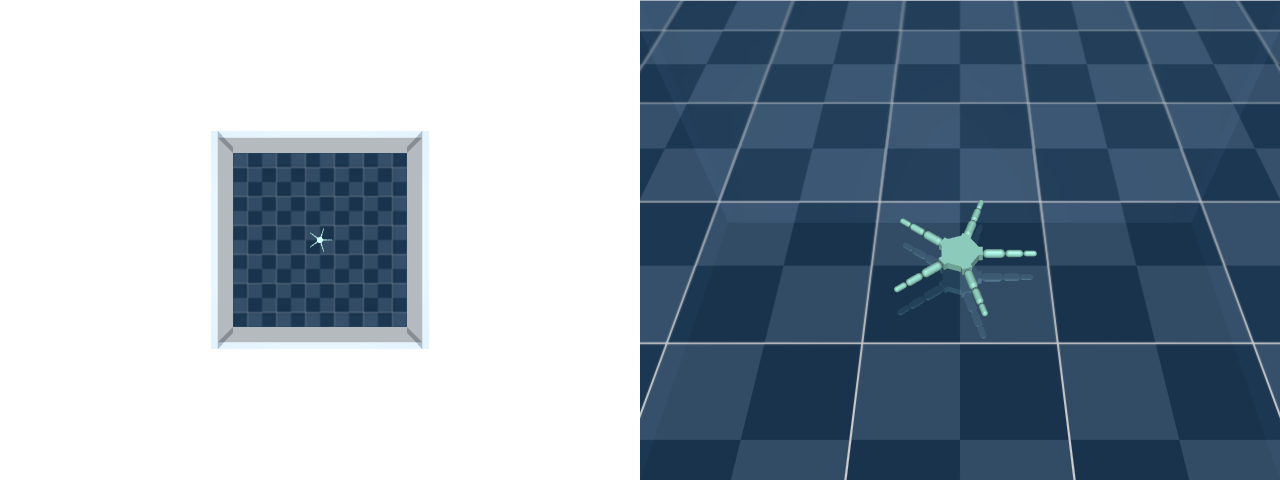

In [5]:
print("Observation space:")
print(env.observation_space)
print()
print("Action space:")
print(env.action_space)
rng, sub_rng = jax.random.split(rng, 2)
env_state = env_reset_fn(rng=sub_rng)
media.show_image(post_render(env.render(env_state), environment_configuration=env.environment_configuration))

### CPG model

We will use the same CPG system as in the CPG tutorial: a system of $N$ coupled amplitude- and offset-controlled phase oscillators. Per arm we will have $2 oscillators$ (one for the in-plane motions and one for the out-of-plane motions, shared over the different segments of an arm). Here we will, however, not couple the oscillators between neighbouring arms. This simplifies things as this alleviates the need to make our phase lags remain consistent, and because this reduces the total amount of modulation parameters.

A candidate solution in this experiment defins the modulation parameters of this CPG system. The modulation parameters are:
- One common frequency shared over all oscillators ($\omega$)
- Two oscillators per arm:
    - Per oscillator: amplitude ($R$) and offset ($X$)
    - The coupling between the oscillators: phase bias $\rho_{ij}$. We will use bi-directional couplings between oscillators such that $\rho_{ij} = -\rho_{ji}$

In this case, we have a $5$ armed brittle star, with $2$ oscillators per arm. We thus have $10$ oscillators in total, resulting in a total amount of $26$ modulation parameters.

The next cell first copies the CPG implementation, the CPG creation (slightly adapted to uncouple the oscillators of neighbouring arms), and the CPG readout function (i.e. CPG state to joint-level actuator actions) from the CPG tutorial.

In [6]:
import functools
from flax import struct
import jax
import jax.numpy as jnp
import chex
from functools import partial
from typing import Tuple

from typing import Callable


def euler_solver(
        current_time: float,
        y: float,
        derivative_fn: Callable[[float, float], float],
        delta_time: float
        ) -> float:
    slope = derivative_fn(current_time, y)
    next_y = y + delta_time * slope
    return next_y


@struct.dataclass
class CPGState:
    time: float
    phases: jnp.ndarray
    dot_amplitudes: jnp.ndarray  # first order derivative of the amplitude
    amplitudes: jnp.ndarray
    dot_offsets: jnp.ndarray  # first order derivative of the offset 
    offsets: jnp.ndarray
    outputs: jnp.ndarray

    # We'll make these modulatory parameters part of the state as they will change as well
    R: jnp.ndarray
    X: jnp.ndarray
    omegas: jnp.ndarray
    rhos: jnp.ndarray


class CPG:
    def __init__(
            self,
            weights: jnp.ndarray,
            amplitude_gain: float = 20,
            offset_gain: float = 20,
            dt: float = 0.01, ) -> None:
        self._weights = weights
        self._amplitude_gain = amplitude_gain
        self._offset_gain = offset_gain
        self._dt = dt
        self._solver = euler_solver

    @property
    def num_oscillators(
            self
            ) -> int:
        return self._weights.shape[0]

    @staticmethod
    def phase_de(
            weights: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray,
            phase_biases: jnp.ndarray,
            omegas: jnp.ndarray
            ) -> jnp.ndarray:
        @jax.vmap  # vectorizes this function for us over an additional batch dimension (in this case over all oscillators)
        def sine_term(
                phase_i: float,
                phase_biases_i: float
                ) -> jnp.ndarray:
            return jnp.sin(phases - phase_i - phase_biases_i)

        couplings = jnp.sum(weights * amplitudes * sine_term(phase_i=phases, phase_biases_i=phase_biases), axis=1)
        return omegas + couplings

    @staticmethod
    def second_order_de(
            gain: jnp.ndarray,
            modulator: jnp.ndarray,
            values: jnp.ndarray,
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:
        return gain * ((gain / 4) * (modulator - values) - dot_values)

    @staticmethod
    def first_order_de(
            dot_values: jnp.ndarray
            ) -> jnp.ndarray:
        return dot_values

    @staticmethod
    def output(
            offsets: jnp.ndarray,
            amplitudes: jnp.ndarray,
            phases: jnp.ndarray
            ) -> jnp.ndarray:
        return offsets + amplitudes * jnp.cos(phases)

    def reset(
            self,
            rng: chex.PRNGKey
            ) -> CPGState:
        phase_rng, amplitude_rng, offsets_rng = jax.random.split(rng, 3)
        # noinspection PyArgumentList
        state = CPGState(
                phases=jax.random.uniform(
                        key=phase_rng, shape=(self.num_oscillators,), dtype=jnp.float32, minval=-0.01, maxval=0.01
                        ),
                amplitudes=jnp.zeros(self.num_oscillators),
                offsets=jnp.zeros(self.num_oscillators),
                dot_amplitudes=jnp.zeros(self.num_oscillators),
                dot_offsets=jnp.zeros(self.num_oscillators),
                outputs=jnp.zeros(self.num_oscillators),
                time=0.0,
                R=jnp.zeros(self.num_oscillators),
                X=jnp.zeros(self.num_oscillators),
                omegas=jnp.zeros(self.num_oscillators),
                rhos=jnp.zeros_like(self._weights)
                )
        return state

    @functools.partial(jax.jit, static_argnums=(0,))
    def step(
            self,
            state: CPGState
            ) -> CPGState:
        new_phases = self._solver(
                current_time=state.time,
                y=state.phases,
                derivative_fn=lambda
                    t,
                    y: self.phase_de(
                        omegas=state.omegas,
                        amplitudes=state.amplitudes,
                        phases=y,
                        phase_biases=state.rhos,
                        weights=self._weights
                        ),
                delta_time=self._dt
                )
        new_dot_amplitudes = self._solver(
                current_time=state.time,
                y=state.dot_amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._amplitude_gain, modulator=state.R, values=state.amplitudes, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_amplitudes = self._solver(
                current_time=state.time,
                y=state.amplitudes,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_amplitudes),
                delta_time=self._dt
                )
        new_dot_offsets = self._solver(
                current_time=state.time,
                y=state.dot_offsets,
                derivative_fn=lambda
                    t,
                    y: self.second_order_de(
                        gain=self._offset_gain, modulator=state.X, values=state.offsets, dot_values=y
                        ),
                delta_time=self._dt
                )
        new_offsets = self._solver(
                current_time=0,
                y=state.offsets,
                derivative_fn=lambda
                    t,
                    y: self.first_order_de(dot_values=state.dot_offsets),
                delta_time=self._dt
                )

        new_outputs = self.output(offsets=new_offsets, amplitudes=new_amplitudes, phases=new_phases)
        # noinspection PyUnresolvedReferences
        return state.replace(
                phases=new_phases,
                dot_amplitudes=new_dot_amplitudes,
                amplitudes=new_amplitudes,
                dot_offsets=new_dot_offsets,
                offsets=new_offsets,
                outputs=new_outputs,
                time=state.time + self._dt
                )


def create_cpg() -> CPG:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    adjacency_matrix = jnp.zeros((10, 10))

    # Connect oscillators within an arm
    adjacency_matrix = adjacency_matrix.at[ip_oscillator_indices, oop_oscillator_indices].set(1)
    adjacency_matrix = adjacency_matrix.at[oop_oscillator_indices, ip_oscillator_indices].set(1)

    return CPG(
            weights=5 * adjacency_matrix,
            amplitude_gain=20,
            offset_gain=20,
            dt=environment_configuration.control_timestep
            )


@jax.jit
def map_cpg_outputs_to_actions(
        cpg_state: CPGState
        ) -> jnp.ndarray:
    num_arms = morphology_specification.number_of_arms
    num_oscillators_per_arm = 2
    num_segments_per_arm = morphology_specification.number_of_segments_per_arm[0]

    cpg_outputs_per_arm = cpg_state.outputs.reshape((num_arms, num_oscillators_per_arm))
    cpg_outputs_per_segment = cpg_outputs_per_arm.repeat(num_segments_per_arm, axis=0)

    actions = cpg_outputs_per_segment.flatten()
    return actions

### Evaluation function

Now we can write our evaluation function, i.e. the function that takes in some parameters and returns the resulting fitness (i.e. the quality score) and behaviour descriptor. In this case, the parameters are the CPG modulation parameters, the fitness is the travelled distance over energy used, and the behaviour descriptor is the final XY position of the robot at the end of the episode.

Let's start by implementing a helper function that takes in parameters and actually modulates the CPG with them.

In [7]:
def modulate_cpg(
        cpg_state: CPGState,
        parameters: jnp.ndarray
        ) -> CPGState:
    ip_oscillator_indices = jnp.arange(0, 10, 2)
    oop_oscillator_indices = jnp.arange(1, 10, 2)

    R = parameters[:10]
    X = parameters[10: 20]
    omega = parameters[21]
    phase_biases = parameters[21:]

    # phase biases is a list of 5 elements, which denote the phase bias between the IP and OOP oscillator of every arm
    rhos = cpg_state.rhos.at[ip_oscillator_indices, oop_oscillator_indices].set(phase_biases)
    rhos = rhos.at[oop_oscillator_indices, ip_oscillator_indices].set(-phase_biases)
    # noinspection PyUnresolvedReferences
    return cpg_state.replace(
            R=R, X=X, omegas=jnp.ones_like(cpg_state.omegas) * omega, rhos=rhos
            )

Now we can implement the actual evaluation function. This function takes in the modulation parameters, modulates the CPG with it, and then uses that CPG to control a brittle star during a single episode. Afterwards, it returns the fitness ($\frac{\mathrm{distance\_travelled}}{\mathrm{energy\_used}}$, with joint actuator forces providing the closest proxy that our simulator can give us to actual "energy usage") and behaviour descriptor (final XY position).

In [8]:
from mujoco_utils.environment.mjx_env import MJXEnvState
from typing import Any, Dict

cpg = create_cpg()


def evaluate_parameters(
        rng: chex.PRNGKey,
        modulation_parameters: jnp.ndarray
        ) -> Tuple[float, jnp.ndarray]:
    env_rng, cpg_rng = jax.random.split(rng, 2)
    env_state = env_reset_fn(rng=env_rng)
    cpg_state = cpg.reset(rng=cpg_rng)

    cpg_state = modulate_cpg(cpg_state=cpg_state, parameters=modulation_parameters)

    def _take_step(
            _state: Tuple[MJXEnvState, CPGState],
            _: None
            ) -> Tuple[Tuple[MJXEnvState, CPGState], Dict[str, Any]]:
        _env_state, _cpg_state = _state

        actions = map_cpg_outputs_to_actions(cpg_state=_cpg_state)
        actions = jnp.clip(a=actions, a_min=env.action_space.low, a_max=env.action_space.high)

        _next_env_state = env_step_fn(state=_env_state, action=actions)
        _next_cpg_state = cpg.step(state=_cpg_state)

        carry = (_next_env_state, _next_cpg_state)
        return carry, jnp.average(jnp.abs(_env_state.observations["joint_actuator_force"]))

    carry, scan_out = jax.lax.scan(
            _take_step, (env_state, cpg_state), (), env.environment_configuration.total_num_control_steps
            )

    
    average_energy_use = jnp.average(scan_out)
    final_xy_position = carry[0].observations["disk_position"][:2]
    final_distance_from_origin = jnp.linalg.norm(final_xy_position)

    fitness = final_distance_from_origin / average_energy_use
    descriptor = final_xy_position

    return fitness, descriptor

### MAP-Elites seetup

We now have everything to create our MAP-Elites instance. We will constrain the behavioural space (i.e. XY positions) to a range of $(-3, 3)$ in both axes, and discretize it a grid of $30\times30$ cells. We also need to define the lower and upper limits for our parameters, which are:
- Amplitude: $(0, 1)$
- Offset: $(-1, 1)$
- Common frequency: $(0, 3\pi)$
- Phase biases: $(-\pi, \pi)$

The noise scale attribute denotes the standard deviation of the normal distribution that we sample mutation noise from.


In [9]:
DESCRIPTOR_LOW = -3 * jnp.ones(2)
DESCRIPTOR_HIGH = 3 * jnp.ones(2)
PARAMETERS_LOW = jnp.concatenate(
        (jnp.zeros(10), -jnp.ones(10), jnp.zeros(1), -jnp.pi * jnp.ones(5))
        )
PARAMETERS_HIGH = jnp.concatenate(
        (jnp.ones(10), jnp.ones(10), 3 * jnp.pi * jnp.ones(1), jnp.pi * jnp.ones(5))
        )

map_elites = MAPElites(
        dimensions=(30, 30),
        num_parameters=31,
        noise_scale=0.1,
        descriptor_low=DESCRIPTOR_LOW,
        descriptor_high=DESCRIPTOR_HIGH,
        parameters_low=PARAMETERS_LOW,
        parameters_high=PARAMETERS_HIGH,
        evaluation_fn=evaluate_parameters
        )

rng, reset_rng = jax.random.split(rng, 2)
state = map_elites.reset(rng=reset_rng)

The next cell does a single iteration of our MAP-Elites algorithm with a single candidate solution (note that the first call will be slow due to jit compilation). Reminder, one MAP-Elites step corresponds to:

1. Selecting an candidate solution from the archive (initially, these will be the randomly initialized ones)
2. Mutating the parameters of that candidate solution to create a new candidate solution
3. Evaluating the fitness and behavioural descriptor of the candidate solution
4. Potentially adding the new candidate solution to the archive (if it is behaviourally new, or better than the previous occupant)

In [10]:
rng, iteration_rng = jax.random.split(rng, 2)

print(f"Number of occupied cells before the step: {jnp.sum(state.filled_mask)}")

state = map_elites.step(
        state=state, rng=iteration_rng
        )

print(f"Number of occupied cells after the step: {jnp.sum(state.filled_mask)}")

Number of occupied cells before the step: 0
Number of occupied cells after the step: 1


### Vectorization
As always, since we're using JAX, we will exploit the power of our GPU and vectorize things. In this case, we will run these MAP-Elites steps in parallel: 

In [11]:
vectorized_iteration = jax.jit(jax.vmap(map_elites.step, in_axes=(None, 0)))

In [12]:
num_parallel_evaluations = 2
rng, *sub_rngs = jax.random.split(key=rng, num=num_parallel_evaluations + 1)
vectorized_state = vectorized_iteration(state, jnp.array(sub_rngs))

print(f"Fitness archive shape:")
print(f"\tState:            {state.fitness_archive.shape}")
print(f"\tVectorized state  {vectorized_state.fitness_archive.shape}")

Fitness archive shape:
	State:            (30, 30)
	Vectorized state  (2, 30, 30)


As you can see, due to the use of [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html), we have introduced a batch dimension in our state.
We will thus need another helper function that can merge these states back into one:  

In [13]:
@jax.jit
def merge_map_elite_states(
        vectorized_state: MAPElitesState
        ) -> MAPElitesState:
    filled_mask = jnp.max(vectorized_state.filled_mask, axis=0)

    fitness_archive = jnp.max(vectorized_state.fitness_archive, axis=0)

    # Keep the parameters corresponding to the best fitness values
    state_indices_of_highest_fitnesses = jnp.argmax(vectorized_state.fitness_archive, axis=0)
    parameter_archive = vectorized_state.parameter_archive[
        state_indices_of_highest_fitnesses, jnp.arange(vectorized_state.parameter_archive.shape[1])[:,
                                            None], jnp.arange(
                vectorized_state.parameter_archive.shape[2]
                )]
    descriptor_archive = vectorized_state.descriptor_archive[
        state_indices_of_highest_fitnesses, jnp.arange(vectorized_state.descriptor_archive.shape[1])[:,
                                            None], jnp.arange(
                vectorized_state.descriptor_archive.shape[2]
                )]

    # noinspection PyArgumentList
    return MAPElitesState(
            filled_mask=filled_mask,
            fitness_archive=fitness_archive,
            parameter_archive=parameter_archive,
            descriptor_archive=descriptor_archive
            )

In [14]:
state = merge_map_elite_states(vectorized_state=vectorized_state)
print(f"Fitness archive shape: {state.fitness_archive.shape}")

Fitness archive shape: (30, 30)


Great! Our final optimisation loop will thus iteratively do a vectorized MAP-Elites step, followed by a merging of the states. As this isn't the simplest optimisation problem, this loop might however take a while until we get nice results (i.e. a diverse set of energy efficient gaits).

Long optimisation loops increase the need for intermediate logging! We never want to be waiting for some results, while unknowingly running a bad or faulty optimisation.
Furthermore, intermediate logging is really important in order to compare different optimisation runs.

### Logging
We will be using [Weights And Biases (W&B)](https://docs.wandb.ai/quickstart) for logging. W&B is an easy-to-use experiment tracker, and allows us to log to an online dashboard (hosted on the cloud) directly from our python code. Before continuing, checkout the following [quickstart](https://docs.wandb.ai/quickstart). Be sure to create and account!

In [15]:
import sys
!{sys.executable} -m pip install -q wandb
import wandb

Now, let's start with defining a function that takes in a state and returns interesting scalar metrics to log:

In [16]:
@jax.jit
def get_scalar_metrics(
        state: MAPElitesState
        ) -> Dict[str, float]:
    return {
            "average-fitness": jnp.sum(jnp.where(state.filled_mask, state.fitness_archive, 0)) / jnp.sum(
                    state.filled_mask
                    ), "maximum-fitness": jnp.max(jnp.where(state.filled_mask, state.fitness_archive, -jnp.inf)),
            "minimum-fitness": jnp.min(jnp.where(state.filled_mask, state.fitness_archive, jnp.inf)),
            "archive-occupancy": jnp.sum(state.filled_mask) / state.filled_mask.size,
            # Since our descriptor is the final XY position, we can also include this:
            "furthest-distance-travelled": jnp.max(
                    jnp.where(state.filled_mask, jnp.linalg.norm(state.descriptor_archive, axis=-1), -jnp.inf)
                    )}

In [17]:
print(get_scalar_metrics(state))

{'archive-occupancy': Array(0.00222222, dtype=float32), 'average-fitness': Array(0.06205, dtype=float32), 'furthest-distance-travelled': Array(0.13993154, dtype=float32), 'maximum-fitness': Array(0.07212202, dtype=float32), 'minimum-fitness': Array(0.05197798, dtype=float32)}


We can also create a cool visualisation: a heatmap of the fitness archive. We'll do this with the [seaborn](https://seaborn.pydata.org/) package, so let's first install that:

In [18]:
!{sys.executable} -m pip install -q seaborn

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image


def create_fitness_archive_heatmap(
        state: MAPElitesState,
        iteration: int
        ) -> np.ndarray:
    # transpose so that we have Y position on the Y axis and X position on the X axis
    data = np.array(state.fitness_archive).T
    data = np.where(data == -np.inf, np.nan, data)
    
    ax = sns.heatmap(data, cmap="coolwarm")  
    ax.invert_yaxis()
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title(f"Fitness archive at iteration: {iteration}")

    cbar = ax.collections[0].colorbar
    cbar.set_label("negated energy usage")
    plt.xticks(ticks=[0, data.shape[1]], labels=[DESCRIPTOR_LOW[0], DESCRIPTOR_HIGH[0]])
    plt.yticks(ticks=[0, data.shape[1]], labels=[DESCRIPTOR_HIGH[1], DESCRIPTOR_LOW[1]])

    # Save heatmap to a buffer
    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)

    image = np.array(Image.open(buf))
    buf.close()
    plt.close()
    
    return image

Now we can implement and run our final vectorized optimisation loop and include logging to wandb! The next code cell might require you to login (just follow the steps). To see the logging dashboard, just click on the generated link! This next cell will take quite some time ($\pm30$ minutes) to complete, as this is already quite a complex optimisation. Perfect time to dive into the papers listed below though!

In [20]:
# Be sure to check out which other arguments you can pass to wandb.init. 'config' and 'group' are very interesting ones to more easily compare experiments later!
wandb.init(
        project="SEL3-2024-QD-Tutorial", )

rng, reset_rng = jax.random.split(rng, 2)
state = map_elites.reset(rng=reset_rng)

num_parallel_evaluations = 512
num_iterations = 100

for iteration in tqdm.tqdm(range(num_iterations), desc="Filling archive"):
    rng, *sub_rngs = jax.random.split(key=rng, num=num_parallel_evaluations + 1)
    vectorized_state = vectorized_iteration(state, jnp.array(sub_rngs))
    state = merge_map_elite_states(vectorized_state)

    metrics = get_scalar_metrics(state)
    wandb.log(data=metrics, step=iteration)
   
    if iteration % 10 == 0 or iteration == num_iterations - 1:
        heatmap = create_fitness_archive_heatmap(state=state, iteration=iteration)
        image = wandb.Image(heatmap)
        wandb.log({"heatmap": image}, step=iteration)
        
# Always finish the wandb run!
wandb.finish()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: driesmarzougui. Use `wandb login --relogin` to force relogin


Filling archive: 100%|██████████| 100/100 [28:07<00:00, 16.87s/it]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


archive-occupancy,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
average-fitness,▁▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████
furthest-distance-travelled,▁▂▃▃▄▃▄▄▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
maximum-fitness,▁▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
minimum-fitness,▁▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█████████████████████
archive-occupancy,0.06556
average-fitness,0.27764
furthest-distance-travelled,0.96192
maximum-fitness,0.44559
minimum-fitness,0.1368


### Result evaluation
Next to the plots on W&B, visualizing the resulting gaits is an important aspect of evaluating the results. Let's create a function that visualizes the episode of a candidate solution (CPG modulation parameters).

In [21]:
def visualize_episode(rng: chex.PRNGKey, modulation_parameters: jnp.ndarray) -> None:
    env_rng, cpg_rng, = jax.random.split(rng, 2) 
    env_state = env_reset_fn(env_rng)
    cpg_state = cpg.reset(cpg_rng)
    
    cpg_state = modulate_cpg(cpg_state=cpg_state, parameters=modulation_parameters)
    
    frames = []
    while not(env_state.terminated | env_state.truncated):
        actions = map_cpg_outputs_to_actions(cpg_state=cpg_state)
        actions = jnp.clip(a=actions, a_min=env.action_space.low, a_max=env.action_space.high)

        env_state = env_step_fn(state=env_state, action=actions)
        cpg_state = cpg.step(state=cpg_state)
        
        frame = post_render(env.render(state=env_state), environment_configuration=environment_configuration)
        frames.append(frame)
    
    show_video(images=frames)

Let's now visualize the episode of the 5 parameter combinations that led to the gaits that walked the furthest.

In [22]:
descriptors = state.descriptor_archive.reshape((-1, 2))
parameters = state.parameter_archive.reshape((-1, len(PARAMETERS_LOW)))
distances = jnp.linalg.norm(descriptors, axis=-1)
sorted_indices = jnp.argsort(distances)[::-1]
for i in range(5):
    modulation_parameters = parameters[sorted_indices[i]]
    rng, vis_rng = jax.random.split(rng, 2)
    visualize_episode(rng=vis_rng, modulation_parameters=modulation_parameters)

## Conclusion

In this tutorial, we have implemented and applied a simple Quality-Diversity technique, MAP-Elites, to evolve a behavioral repertoire of brittle star gaits. Instead of directly evolving controllers that output joint-level motor commands, we evolved the modulation parameters of a CPG system that produces these commands in an open-loop fashion.

The main goal of this tutorial was to give you a basic understanding of Quality-Diversity, and a minimal setup to play around with it to gain more intuition. While this minimal setup has already given us some interesting results, there is still a lot of room for improvements (see the next section).

In essence, the end goal of the Quality-Diversity track in this project will be to generate a diverse and qualitative set of motion primitives for the brittle star. These motion primitives can both comprise complete rowing gaits, or lower-level arm or even segment motions. This behavioural reportoire can then be used by an adaptive controller (e.g. trained by reinforcement learning) that can select motion primitives from it based on observations. Having such a behavioural reportoire at hand can greatly simplify the learning task for that higher-level controller, as it alleviates the need to learn these motion primitives from scratch.

You will initially work in an open loop setting...
You'll need to think about how fitness and behaviour can be defined...

## Some recommended next steps

As the results of our first experiment demonstrate, we lack behavioural realism in the evolved gaits: we did not evolve rowing motions! The main reason for this is that we did not explicitly "tell" evolution to produce realistic gaits. Evolutionary optimization is known to produce 'creative' results, that often solve tasks in unexpected manners. An interesting collection of anecdotes on this can be read [here](https://direct.mit.edu/artl/article-abstract/26/2/274/93255). This kind of problem is often mitigated by enriching the fitness function: we could for instance stimulate rowing motions by giving a fitness penalty when the brittle star's central disk rotates too much. Nevertheless, many other options to mitigate this issue and to stimulate more realistic behavior exist. This will be one of the main objectives for the quality-diversity track during this project: evolving a diverse and qualitative (i.e. both performant and realistic) set of motion primitives.

Here are some possible next steps for you to work on:
* Improvements for the evolutionary algorithm:
    * The different parameters currently have different ranges (e.g. amplitude is bounded between $(0, 1)$, while phase biases are bounded between $(-\pi, \pi)$). However, when we mutate these parameters, we use the same mutation noise scale. This means that we vary the parameters with smaller ranges way more than parameters with bigger ranges, which is not desirable.
    * Incorporate and test cross-over (i.e. mixing the parameters of two candidate solutions).
    * Enrich the fitness function to stimulate more realistic gaits (e.g. by incorporating the notion of disk stability).
* General experimental setup
    * Incorporate our prior knowledge on brittle star rowing behavior. We know that brittle stars rowing behaviour assigns a distinct role to each arm, i.e. a leading arm, two front rowers and two hind rowers. We can exploit this knowledge by not evolving parameters for each arm distinctly, but by evolving parameters for each role instead. The `modulate_cpg` function must then assign the modulation parameters for each role to a specific arm. In this case we will also shift from locomotion in any direction to forward locomotion (we want to row in the direction of the leading arm). This should be stimulated by the fitness function. The behavioural descriptor should create niches based on how the different roles behave during this rowing gait.
    * Undo the sharing of oscillators between the segments of a single arm. This will allow more complex behaviours to be evolved.
 
The quality-diversity framework allows for many different methodological paths. Below are some interesting papers that propose interesting approaches that you can apply to our objective of evolving a behavioural repertoire for brittle star locomotion.

## Recommended reading material

* [Quality-Diversity Optimization: a novel branch of stochastic optimization](https://arxiv.org/abs/2012.04322)
* [Illuminating search spaces by mapping elites](https://arxiv.org/abs/1504.04909)
* [using Centroidal Voronoi Tessellations to Scale Up the Multi-dimensional Archive of Phenotypic Elites algorithm](https://arxiv.org/abs/1610.05729)
* [Hierarchical Behavioral Repertoires with Unsupervised Descriptors](https://arxiv.org/abs/1804.07127)
* [Covariance Matrix Adaptation for the Rapid Illumination of
Behavior Space](https://arxiv.org/pdf/1912.02400.pdf)